In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import atmos

In [41]:
def chuck_data_helper(save_name, column_names):
    try:
        df = pd.read_parquet(save_name)
    except:
        df = pd.read_clipboard(names=column_names)
        df.to_parquet(save_name)
    return df

In [ ]:
activity_df = chuck_data_helper(save_name='activity_data', column_names=['time','distance','power','cadence','heartrate','speed','altitude','lat','long','slope'])
activity_df['speed'] = activity_df['speed']*1000/60/60
activity_df['acceleration'] = (activity_df['speed']-activity_df['speed'].shift(1))
activity_df['time'] = activity_df['time'].apply(lambda x: int(x.replace(',','')))

In [8]:
weather_df = chuck_data_helper(save_name='weather_data', column_names=['Time','distance','TEMPERATURE','HUMIDITY','WINDSPEED','WINDDIRECTION','PRESSURE'])

In [9]:
intervals = [
#    (15*60+15,16*60+47)
    (2*60+ 30, 3*60+ 24)
    ,(8*60+ 9, 8*60+ 51)
    ,(13*60+ 49, 14*60+ 29)
    ,(24*60+ 18, 25*60+ 0)
    ,(29*60+ 25, 30*60+ 7)
]

In [10]:
closest_weather_reading_idx = abs((weather_df['Time'] - intervals[0][0]) + (weather_df['Time'] - intervals[0][1])).argmin()
closest_weather_reading = weather_df.loc[closest_weather_reading_idx]
rho_inputs = {'p':closest_weather_reading['PRESSURE']
             ,'T':273+closest_weather_reading['TEMPERATURE']
             ,'RH':closest_weather_reading['HUMIDITY']/100}

In [11]:
rho = atmos.calculate('rho', **rho_inputs)

In [12]:
Crr = .005
CdA = .3
athlete_mass = 84
bike_mass = 7.6
gear_mass = 1.5
system_mass = athlete_mass + bike_mass + gear_mass
gravity = 9.81

In [13]:
def solve_power(Crr, m, g, v, s, a, CdA, rho, v_air):

    return w
def solve_power_nowind(Crr, m, g, v, a, CdA, rho, w):
    Crr = Crr*1000
    CdA = CdA*100
    s = w / (m*g*v) - Crr - a/g - (rho*CdA*v**2)/(2*m*g)
    return s

## Test function & dataflow

In [16]:
def interval_extract(data, interval_start, interval_end):
    return data[(data['time'] >= interval_start) & (data['time'] <= interval_end)]

In [32]:
interval_df = interval_extract(activity_df, interval_start=intervals[0][0], interval_end=intervals[0][1])
results = {}
for CdA in range(18,32):
    CdA = CdA/100
    results[CdA] = solve_power_nowind(Crr=Crr, CdA=CdA, m=system_mass, g=gravity, v=interval_df['speed'], a=interval_df['acceleration'], rho=rho, w=interval_df['power']).cumsum()
results['actual'] = interval_df['slope'].cumsum()

<AxesSubplot:>

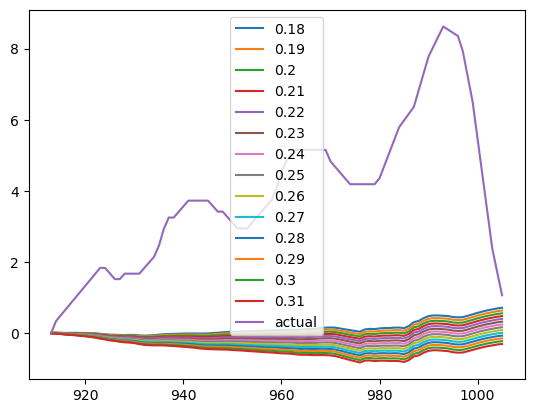

In [33]:
pd.DataFrame(results).plot()

In [40]:
interval_df = interval_extract(activity_df, interval_start=intervals[0][0], interval_end=intervals[0][1])

def optimize_CdA(params):    
    losses = []

    pred_slope_change = solve_power_nowind(Crr=params[1], CdA=params[0], m=system_mass, g=gravity, v=interval_df['speed'], a=interval_df['acceleration'], rho=rho, w=interval_df['power'])
    
    losses = abs(activity_df['altitude'] - pred_slope_change)
    MAE = np.mean(losses)
    print(params[0], params[1], MAE)
    return MAE
                # CdA  Crr
initial_guess  = [.3*100, .005*1000*100]
modeled_CdA = scipy.optimize.minimize(optimize_CdA
                                            ,x0=initial_guess
                                                    # CdA          Crr
                                            ,bounds=[(.15*100,0.40*100),(.004*1000,0.007*1000)]
                                            # ,method='Nelder-Mead'
                                            ,tol=1e-2
                                            )
print(modeled_CdA)
for val in modeled_CdA['x']:
    print(val)

30.0 7.0 17.988668186423634
30.00000001 7.0 17.9886681872657
30.0 6.99999999 17.988668176423648
29.91579358735234 6.0000013322676375 16.98157889909018
29.91579359735234 6.0000013322676375 16.98157889993224
29.91579358735234 6.0000013422676375 16.98157890909018
29.83158752997602 5.000001243449795 15.974488220586952
29.83158753997602 5.000001243449795 15.974488221429004
29.83158752997602 5.000001253449795 15.974488230586939
29.747381375372704 4.0 14.967396379264725
29.747381385372705 4.0 14.967396380106784
29.747381375372704 4.00000001 14.967396389264746
29.663175495632053 4.0 14.960305804537192
29.663175505632054 4.0 14.960305805379246
29.663175495632053 4.00000001 14.960305814537184
29.32635197666945 4.0 14.931943505627006
29.32635198666945 4.0 14.931943506469063
29.32635197666945 4.00000001 14.931943515627
27.979057900819036 4.0 14.81849430998628
27.979057910819037 4.0 14.818494310828328
27.979057900819036 4.00000001 14.818494319986272
22.58988159741738 4.0 14.364697527423347
22.58988